# Big Data Project
Buongiorno a tutti

In [1]:
# inizializziamo la SparkSession e importiamo le librerie
import findspark

location = findspark.find()
findspark.init(location)

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession \
    .builder \
    .appName("Spark ML example on Credit Card data") \
    .getOrCreate()

21/10/06 18:46:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Lettura del file da hdfs con spark e conteggio delle colonne con valori nulli/NaN

In [2]:
dataSet = spark.read \
    .csv('hdfs://localhost:9099/creditCardProject/creditcard.csv', header = 'True', inferSchema='True')

nullValues = dataSet.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dataSet.columns])
nullValues.show()

21/10/06 18:46:20 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



Convertiamo in Pandas per una gestione più semplice per poter fare i grafici

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt

df = dataSet.toPandas()

Grafico X: Amount --> Y: Class

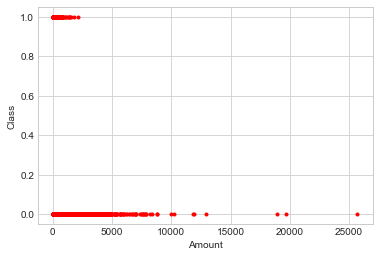

In [4]:
X = df['Amount']
Y = df['Class']

plt.style.use('seaborn-whitegrid')
plt.xlabel("Amount")
plt.ylabel("Class")
plt.scatter(X, Y, marker = ".", color = 'red')
plt.show()

È possibile dedurre che il dataset è sbilanciato e che le transazioni con class = 1 (frodi) hanno un valore di Amount relativamente basso (< 5000).

Grafico: X: Time -- Y:Amount (Rosso frode - Blu non frode)

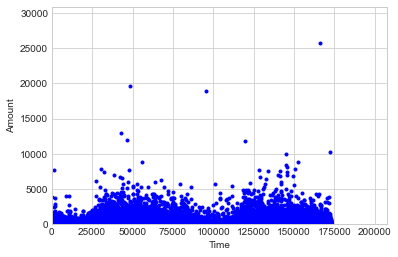

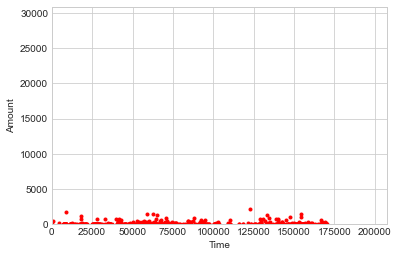

In [5]:
#Grafico non frode
xlim = df['Time'].max() * 1.2
ylim = df['Amount'].max() * 1.2

X = np.where(df['Class']==0, df['Time'], None)
Y = np.where(df['Class']==0, df['Amount'], None)

plt.style.use('seaborn-whitegrid')
plt.xlabel("Time")
plt.ylabel("Amount")
plt.scatter(X, Y, marker = ".", color = "blue")
plt.xlim(0, xlim)
plt.ylim(0, ylim)
plt.show()

#Grafico frode
X = np.where(df['Class']==1, df['Time'], None)
Y = np.where(df['Class']==1, df['Amount'], None)

plt.style.use('seaborn-whitegrid')
plt.xlabel("Time")
plt.ylabel("Amount")
plt.xlim(0, xlim)
plt.ylim(0, ylim)
plt.scatter(X, Y, marker = ".", color = "red")
plt.show()

Secondo me (Davide) è possibile fare discorsi sulla colonna Time, eliminabile a prescindere

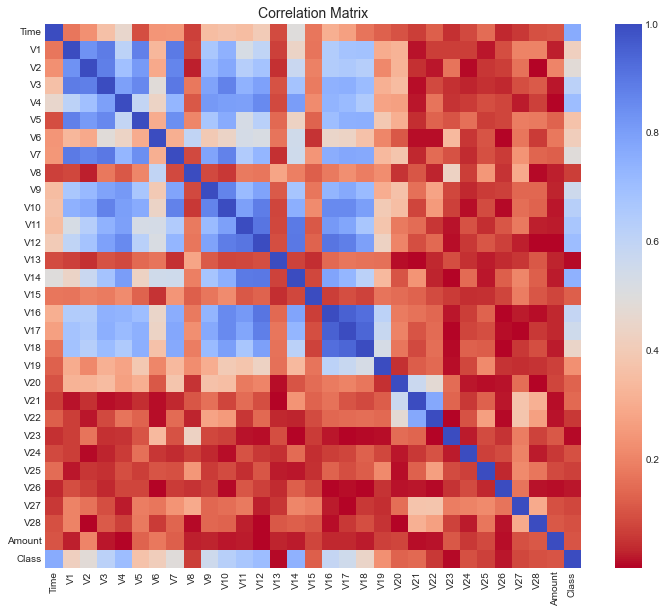

In [6]:
import seaborn as sns

# shuffle before creating subsamples

df_fraud = df.loc[df.Class == 1]
df_non_fraud = df.loc[df.Class == 0][1000:1492]

dfFifty = pd.concat([df_fraud, df_non_fraud])

plt.figure(figsize=(12, 10))
corr = dfFifty.corr()
corr = pd.DataFrame.abs(corr)
fig = sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})
fig.set_title('Correlation Matrix', fontsize=14)
plt.show()

Calcolo matrice di covarianza per capire quali attributi è possibile eliminare

In [24]:
soglia = 0.05
#print(corr["Class"] < soglia)
#droppiamo V13 e V23 perchè minori della soglia
dfFinal = df.drop(["V13", "V23"], axis = 1)

X = dfFinal.iloc[:, dfFinal.columns != 'Class']
y = dfFinal.iloc[:, dfFinal.columns == 'Class']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3, random_state = 50)

from sklearn.metrics import recall_score
from sklearn.neural_network import MLPClassifier

MLPC = MLPClassifier(hidden_layer_sizes=(200,), max_iter=10000)
MLPC.fit(X_train, y_train.values.ravel())
y_pred = MLPC.predict(X_test)
# Obtenemos valores de recall
recall_acc = recall_score(y_test,y_pred)
print(recall_acc)

0.5374149659863946


In [25]:
X_prova = np.array([6986,-4.39797444171999,1.35836702839758,-2.5928442182573,2.67978696694832,-1.12813094208956,-1.70653638774951,-3.49619729302467,-0.248777743025673,-0.24776789948008,-4.80163740602813,4.89584422347523,-10.9128193194019,-6.77109672468083,-0.00732618257771211,-7.35808322132346,-12.5984185405511,-5.13154862842983,0.308333945758691,-0.17160787864796,0.573574068424352,0.176967718048195,-0.0535018648884285,0.252405261951833,-0.657487754764504,-0.827135714578603,0.849573379985768,59])
X_prova = np.reshape(X_prova, (1, -1))
print(MLPC.predict(X_prova))
print(MLPC.n_layers_)

[1]
3


In [8]:
dfFinal = df

X = dfFinal.iloc[:, dfFinal.columns != 'Class']
y = dfFinal.iloc[:, dfFinal.columns == 'Class']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3, random_state = 0)

from sklearn.metrics import recall_score
from sklearn.neural_network import MLPClassifier

MLPC = MLPClassifier(hidden_layer_sizes=(200,), max_iter=10000)
MLPC.fit(X_train, y_train.values.ravel())
y_pred = MLPC.predict(X_test)
# Obtenemos valores de recall
recall_acc = recall_score (y_test,y_pred)

In [9]:
X_prova = np.array([164097,-0.651460069065708,1.21394427180896,-1.84704679138207,-0.12267372248778,3.16012539582766,3.51131824340493,0.365948728333773,1.19914048559518,-0.899041372976988,-0.0777540313298352,-0.517029425538766,0.0359440654051498,-0.398573349807846,0.973839437664193,0.032741748116327,-1.11561764801964,0.216696705998021,-0.363452580835941,0.703228322662521,0.0099447627437792,0.164006031105811,0.495901453286591,-0.193589789139418,0.717744604957157,0.0915765637406466,-0.367407118510733,0.19748520942453,0.169475069953218,4.49])
X_prova = np.reshape(X_prova, (1, -1))
print(MLPC.predict(X_prova))
print(recall_acc)
print(dfFinal)

[0]
0.6938775510204082
            Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599  0.098698 

Divisione del dataset in training set e validation set

Creazione del modello di predizione

Valutazione dell'errore del modello ottenuto al passo precedente